In [1]:
# Import 
import os
import sys
import importlib.util
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Project root 
notebook_dir = Path.cwd()
root = (notebook_dir / '..' / '..').resolve()

In [2]:
# Load ETF prices and prepare test dates
from pathlib import Path
data_dir = Path.cwd().parent.parent / 'data'
prices_csv = data_dir / 'etf_prices.csv'
prices = pd.read_csv(prices_csv, index_col=0, parse_dates=True)
print(f"Prices loaded: shape={prices.shape}, {prices.index.min().date()} -> {prices.index.max().date()}")

# Requested test window
TEST_START = '2025-01-01'
TEST_END = '2025-07-01'

prices_test = prices.loc[TEST_START:TEST_END]
print(f"Test slice: {prices_test.index.min().date()} -> {prices_test.index.max().date()}, days={len(prices_test)}")

# Save outputs to the same folder as this notebook (analysis/visuals)
vis_dir = Path.cwd()
vis_dir.mkdir(parents=True, exist_ok=True)
full_prices_png = str(vis_dir / 'etf_prices_plot.png')
test_prices_png = str(vis_dir / 'etf_prices_test_period.png')

Prices loaded: shape=(3155, 10), 2013-01-02 -> 2025-07-18
Test slice: 2025-01-02 -> 2025-07-01, days=123


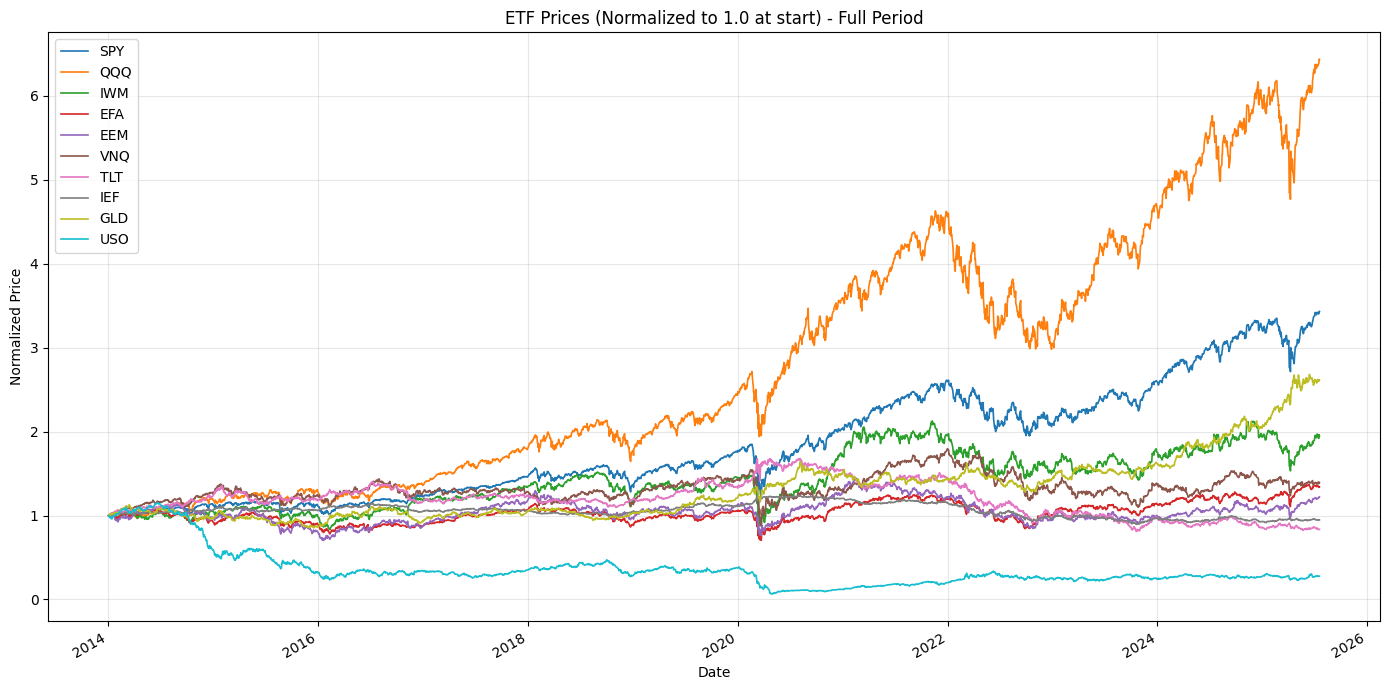

Saved: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\visuals\etf_prices_plot.png


In [3]:
# Full-period ETF prices chart (force start from 2014-01-01)
start_date = '2014-01-01'
prices_plot = prices.loc[start_date:] if start_date in prices.index or prices.index.min() <= pd.to_datetime(start_date) else prices
plt.figure(figsize=(14, 7))
(prices_plot / prices_plot.iloc[0]).plot(ax=plt.gca(), linewidth=1.2)
plt.title('ETF Prices (Normalized to 1.0 at start) - Full Period')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(full_prices_png, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {full_prices_png}")

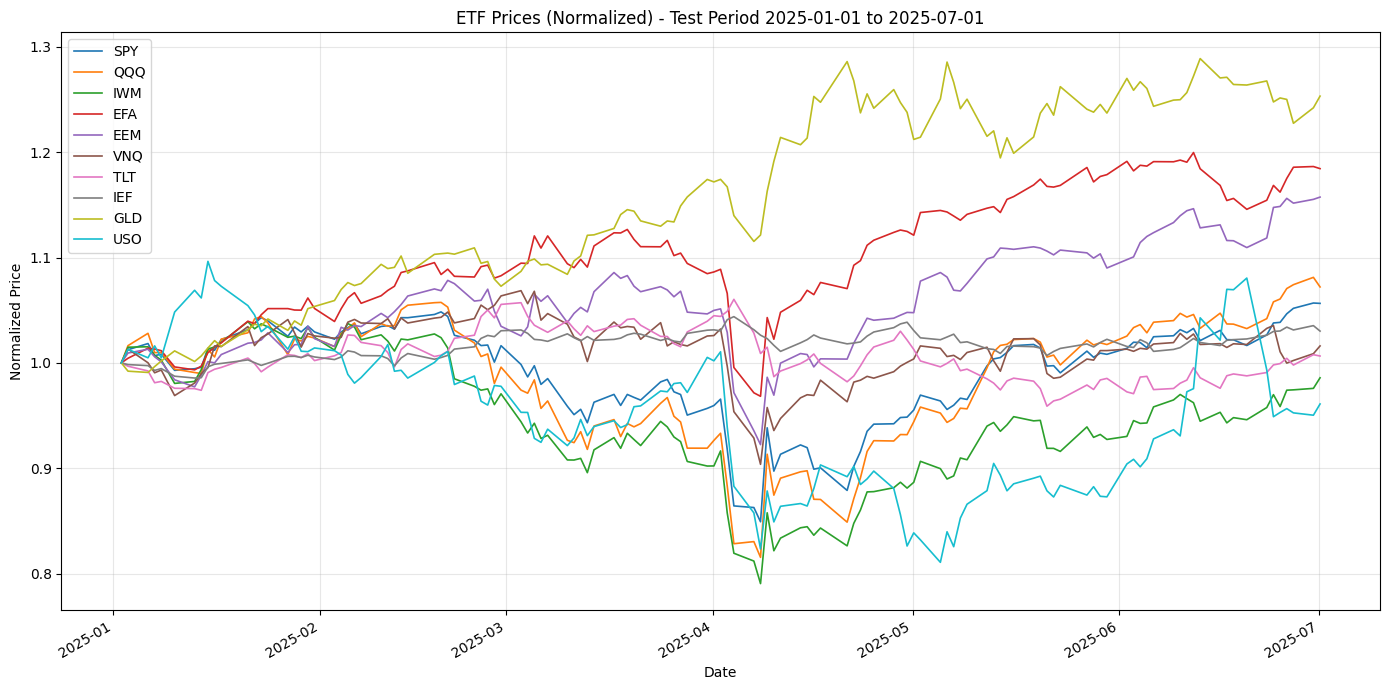

Saved: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\visuals\etf_prices_test_period.png


In [4]:
# Test-period ETF prices chart
if len(prices_test) > 0:
    plt.figure(figsize=(14, 7))
    (prices_test / prices_test.iloc[0]).plot(ax=plt.gca(), linewidth=1.2)
    plt.title(f'ETF Prices (Normalized) - Test Period {TEST_START} to {TEST_END}')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(test_prices_png, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"Saved: {test_prices_png}")


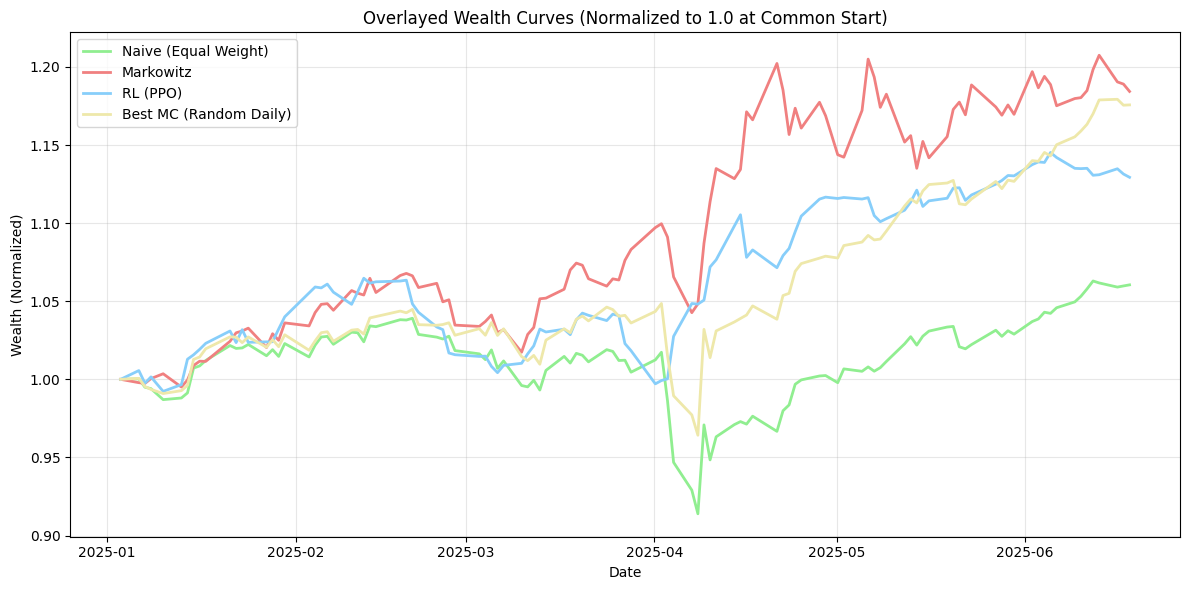

Saved overlay plot to: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\visuals\overlay_wealth_curves.png
Included best MC wealth path from mc_best_path.csv


In [5]:
# Overlayed wealth curves (RL, Markowitz, Naive, and optional Best MC path)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths
project_root = Path.cwd().parent.parent
rl_csv = project_root / 'results' / 'rl_daily_results_refit.csv'
markowitz_csv = project_root / 'markowitz' / 'markowitz_outputs' / 'wealth_series.csv'
prices_csv = project_root / 'data' / 'etf_prices.csv'
mc_best_csv = project_root / 'analysis' / 'mc' / 'mc_best_path.csv'

# Load RL wealth
rl_df = pd.read_csv(rl_csv, parse_dates=['date'])
rl_df = rl_df[['date','cumulative_wealth']].rename(columns={'cumulative_wealth':'RL'})

# Load Markowitz wealth
mk_df = pd.read_csv(markowitz_csv, parse_dates=['date'])
wealth_col = [c for c in mk_df.columns if c != 'date'][0]
mk_df = mk_df.rename(columns={wealth_col:'Markowitz'})

# Recompute Naive equal-weight wealth over RL window
etfs = ['SPY','QQQ','IWM','EFA','EEM','VNQ','TLT','IEF','GLD','USO']
prices = pd.read_csv(prices_csv, index_col=0, parse_dates=True)[etfs]
start_date = rl_df['date'].min()
end_date = rl_df['date'].max()
prices_slice = prices.loc[start_date:end_date]
naive_returns = prices_slice.pct_change().dropna().mean(axis=1)
naive_wealth = (1 + naive_returns).cumprod()
naive_df = naive_wealth.reset_index().rename(columns={'index':'date',0:'Naive'})
if 'Naive' not in naive_df.columns:
    naive_df = naive_df.rename(columns={naive_df.columns[1]:'Naive'})

# Merge core three
merged = (rl_df.merge(mk_df, on='date', how='inner')
                .merge(naive_df, on='date', how='inner'))

# Optionally load MC best path
mc_present = False
if mc_best_csv.exists():
    mc_df = pd.read_csv(mc_best_csv, parse_dates=['date'])
    # Ensure overlapping window and consistent normalization base
    mc_df = mc_df[['date','best_mc_wealth']]
    merged = merged.merge(mc_df, on='date', how='inner')
    mc_present = 'best_mc_wealth' in merged.columns

# Normalize all series to 1.0 at first common date
for col in ['RL','Markowitz','Naive'] + (['best_mc_wealth'] if mc_present else []):
    merged[col] = merged[col] / merged[col].iloc[0]

plt.figure(figsize=(12,6))
plt.plot(merged['date'], merged['Naive'], label='Naive (Equal Weight)', linewidth=2, color='lightgreen')
plt.plot(merged['date'], merged['Markowitz'], label='Markowitz', linewidth=2, color='lightcoral')
plt.plot(merged['date'], merged['RL'], label='RL (PPO)', linewidth=2, color='lightskyblue')
if mc_present:
    plt.plot(merged['date'], merged['best_mc_wealth'], label='Best MC (Random Daily)', linewidth=2, color='palegoldenrod')

plt.title('Overlayed Wealth Curves (Normalized to 1.0 at Common Start)')
plt.xlabel('Date')
plt.ylabel('Wealth (Normalized)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
out_path = Path.cwd() / 'overlay_wealth_curves.png'
plt.savefig(out_path, dpi=200, bbox_inches='tight')
plt.show()
print(f'Saved overlay plot to: {out_path}')
if mc_present:
    print('Included best MC wealth path from mc_best_path.csv')
else:
    print('mc_best_path.csv not found; MC best path not included.')

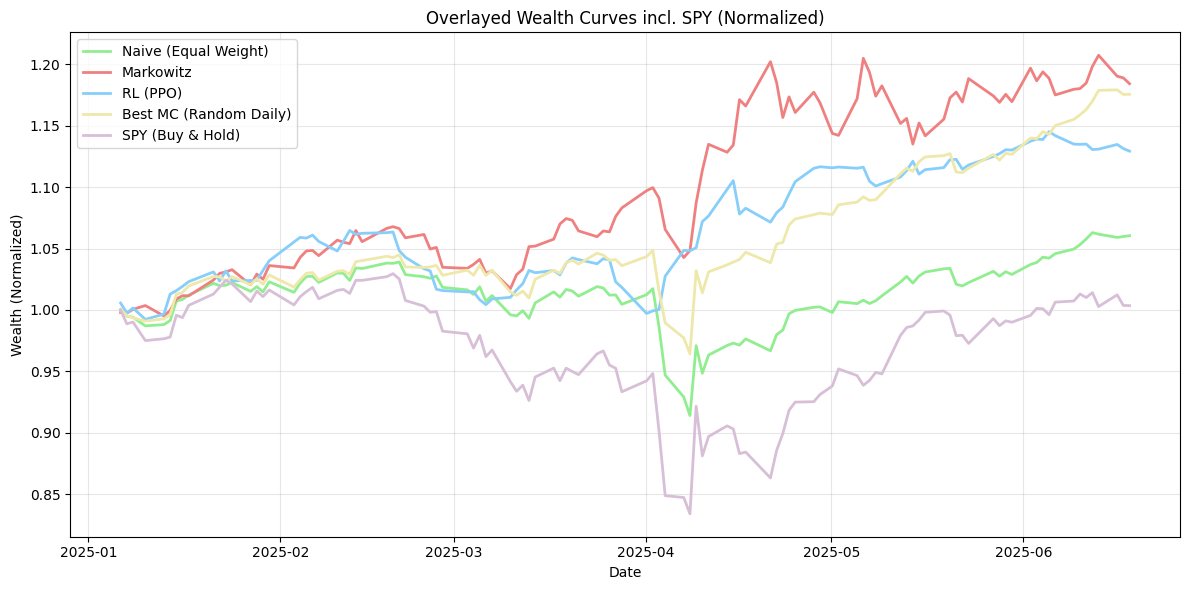

Saved extended overlay plot with SPY to: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\visuals\overlay_wealth_curves_with_spy.png

SPY metrics:
Annualized Excess Return: 1.49%
Annualized Volatility (excess std basis): 26.48%
Sharpe: 0.06
Max Drawdown: -19.00%
CAGR: 0.78%

LaTeX row to add:
SPY (Buy \& Hold) & 1.49\% & 26.48\% & 0.06 & -19.00\% & 0.78\% \


In [6]:
# Add SPY (buy & hold) metrics and extended overlay plot including SPY
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumes previous cell created variables: merged (RL/Markowitz/Naive (+ optional best_mc_wealth)),
# prices (full price DataFrame with ETF columns), and start/end dates via rl_df.
# Reconstruct SPY wealth over the merged date range.

if 'merged' not in globals():
    raise RuntimeError("Expected 'merged' DataFrame from prior cell not found. Re-run previous overlay cell first.")

# Derive date range from merged
start_date = merged['date'].min()
end_date = merged['date'].max()

# Load prices if not already loaded
if 'prices' not in globals():
    project_root = Path.cwd().parent.parent
    prices_csv = project_root / 'data' / 'etf_prices.csv'
    prices = pd.read_csv(prices_csv, index_col=0, parse_dates=True)

spy_series = prices.loc[start_date:end_date, 'SPY'].copy()
if spy_series.isna().all():
    raise ValueError("SPY price series is empty or NaN in the selected date range.")

# Compute SPY wealth (normalized) and daily returns
spy_returns = spy_series.pct_change().dropna()
spy_wealth = (1 + spy_returns).cumprod()

# Prepare SPY DataFrame aligned for merge
spy_df = spy_wealth.reset_index().rename(columns={'index':'date','SPY':'SPY_wealth'})
if 'SPY_wealth' not in spy_df.columns:
    # If auto renaming created numeric column name
    col2 = spy_df.columns[1]
    spy_df = spy_df.rename(columns={col2:'SPY_wealth'})

# Merge (inner to retain common dates)
merged_spy = merged.merge(spy_df.rename(columns={'SPY_wealth':'SPY'}), on='date', how='inner')

# Normalize SPY to 1.0 at first common date to match existing normalization already done for others
if merged_spy['SPY'].iloc[0] != 1.0:
    merged_spy['SPY'] = merged_spy['SPY'] / merged_spy['SPY'].iloc[0]

# Plot extended overlay including SPY
plt.figure(figsize=(12,6))
plt.plot(merged_spy['date'], merged_spy['Naive'], label='Naive (Equal Weight)', linewidth=2, color='lightgreen')
plt.plot(merged_spy['date'], merged_spy['Markowitz'], label='Markowitz', linewidth=2, color='lightcoral')
plt.plot(merged_spy['date'], merged_spy['RL'], label='RL (PPO)', linewidth=2, color='lightskyblue')
if 'best_mc_wealth' in merged_spy.columns:
    plt.plot(merged_spy['date'], merged_spy['best_mc_wealth'], label='Best MC (Random Daily)', linewidth=2, color='palegoldenrod')
plt.plot(merged_spy['date'], merged_spy['SPY'], label='SPY (Buy & Hold)', linewidth=2, color='thistle')
plt.title('Overlayed Wealth Curves incl. SPY (Normalized)')
plt.xlabel('Date')
plt.ylabel('Wealth (Normalized)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
out_path_spy = Path.cwd() / 'overlay_wealth_curves_with_spy.png'
plt.savefig(out_path_spy, dpi=200, bbox_inches='tight')
plt.show()
print(f'Saved extended overlay plot with SPY to: {out_path_spy}')

# Compute SPY metrics for LaTeX table row
rf_daily = 0.04 / 252.0
excess_returns = spy_returns - rf_daily
annualized_excess_return = excess_returns.mean() * 252
annualized_vol = excess_returns.std(ddof=1) * np.sqrt(252)
sharpe = annualized_excess_return / annualized_vol if annualized_vol > 0 else np.nan
n_days = len(spy_returns)
if n_days > 1:
    cagr = (spy_wealth.iloc[-1] / spy_wealth.iloc[0]) ** (252 / n_days) - 1
else:
    cagr = np.nan
running_max = spy_wealth.cummax()
drawdowns = spy_wealth / running_max - 1.0
max_dd = drawdowns.min()

print('\nSPY metrics:')
print(f'Annualized Excess Return: {annualized_excess_return:.2%}')
print(f'Annualized Volatility (excess std basis): {annualized_vol:.2%}')
print(f'Sharpe: {sharpe:.2f}')
print(f'Max Drawdown: {max_dd:.2%}')
print(f'CAGR: {cagr:.2%}')

# Output LaTeX table row (align with existing columns: Portfolio & AnnExcessRet & Vol & Sharpe & MaxDD & CAGR)
print('\nLaTeX row to add:')
print(f'SPY (Buy \\& Hold) & {annualized_excess_return*100:.2f}\% & {annualized_vol*100:.2f}\% & {sharpe:.2f} & {max_dd*100:.2f}\% & {cagr*100:.2f}\% \\')

# Provide merged_spy for any further analysis
merged_with_spy = merged_spy.copy()